In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
train_ds = "../input/csc4851-homework4/birds_400/train"
test_ds = "../input/csc4851-homework4/birds_400/test"
val_ds = "../input/csc4851-homework4/birds_400/valid"

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_ds,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 32
                                                                     )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_ds,
                                                                    label_mode = "categorical",
                                                                    image_size = (224,224),
                                                                    batch_size = 32
                                                                    )
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_ds,
                                                                   label_mode= "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   )

Found 58388 files belonging to 400 classes.


2022-03-29 05:00:35.672894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 05:00:35.798557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 05:00:35.799282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 05:00:35.801446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


2022-03-29 05:00:39.306527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


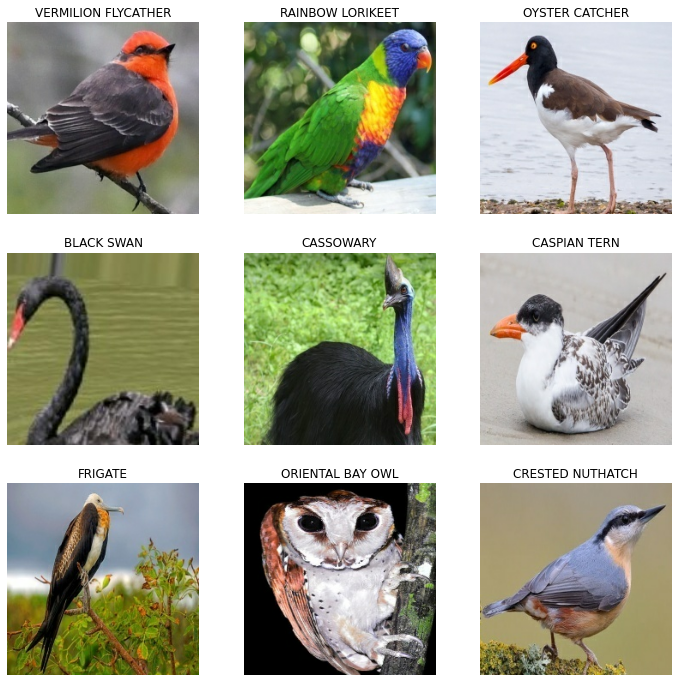

In [4]:
labels = train_data.class_names
plt.figure(figsize=(12,12))
for image, label in train_data.take(1):
  
  for i in range(9):
    
    plt.subplot(3,3, i+1)  
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[tf.argmax(label[i])])
    plt.axis("off")

In [5]:
model = tf.keras.applications.EfficientNetB5(include_top= False, weights = "imagenet")

115277824/115263384 [==============================] - 1s 0us/step


In [6]:
from tensorflow.keras import layers

for layer in model.layers[:-5]:
    model.trainable = False


ip = tf.keras.Input(shape=(224,224,3))

mod = model(ip)
mod = layers.GlobalAveragePooling2D()(mod)

op = layers.Dense(400, activation="sigmoid")(mod)

model_2 = tf.keras.Model(ip,op)
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, None, None, 2048)  28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               819600    
Total params: 29,333,127
Trainable params: 819,600
Non-trainable params: 28,513,527
_________________________________________________________________


In [7]:
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [8]:
model_2.fit(train_data,
              epochs = 5,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data)
              )

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-03-29 05:01:09.508346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1825/1825 [==============================] - 283s 145ms/step - loss: 0.0159 - accuracy: 0.6877 - val_loss: 0.0035 - val_accuracy: 0.9340
Epoch 2/5
1825/1825 [==============================] - 267s 146ms/step - loss: 0.0035 - accuracy: 0.9020 - val_loss: 0.0019 - val_accuracy: 0.9560
Epoch 3/5
1825/1825 [==============================] - 259s 142ms/step - loss: 0.0023 - accuracy: 0.9317 - val_loss: 0.0014 - val_accuracy: 0.9650
Epoch 4/5
1825/1825 [==============================] - 265s 145ms/step - loss: 0.0018 - accuracy: 0.9495 - val_loss: 0.0012 - val_accuracy: 0.9695
Epoch 5/5
1825/1825 [==============================] - 271s 148ms/step - loss: 0.0014 - accuracy: 0.9613 - val_loss: 0.0010 - val_accuracy: 0.9725


In [9]:
model_2_eval = model_2.evaluate(test_data)

63/63 [==============================] - 9s 132ms/step - loss: 8.3628e-04 - accuracy: 0.9835


In [10]:
print(f"Model Accuracy: {model_2_eval[1]*100 : 0.2f}%")

Model Accuracy:  98.35%


In [11]:
from keras.preprocessing import image
from keras import losses
from sklearn.metrics import log_loss
from glob import glob
import os
import csv 

In [12]:
test_labels = test_data.class_names

len(test_labels)

400

In [13]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/224
    return np.expand_dims(x, axis=0)
bce = losses.BinaryCrossentropy()

In [14]:
template = [0]*400
log_loss = {}
test_images = glob("/kaggle/input/csc4851-homework4/birds_400/test/" + "/.jpg")

for path in test_images:
    result = model_2.predict([prepare(path)])
    actual_class = train_ds.split('/')[-2]
    actual_class = "BLACK & YELLOW  BROADBILL" if actual_class == "BLACK & YELLOW BROADBILL" else actual_class
    actual_index = classes.index(actual_class)
    template[actual_index] = 1
    log_loss_current = bce(template, result[0]).numpy()
    if actual_index in log_loss:
        log_loss[actual_index] += (log_loss_current)/100
    else:
        log_loss[actual_index] = (log_loss_current)/100
    template[actual_index] = 0
    
log_loss

{}

In [15]:
ids = list(log_loss.keys())
values = list(log_loss.values())
f = open('submission.csv', 'w')
writer = csv.writer(f)
writer.writerow(['id','birds'])
for index in range(len(ids)):
    writer.writerow([ids[index],values[index]])
